In [1]:
import pandas as pd
import numpy as np

In [46]:
df_raw = pd.read_csv("../data/train_logs.csv")
df_raw.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


**id** - The unique ID of the essay

**event_id** - The index of the event, ordered chronologically

**down_time** - The time of the down event in milliseconds

**up_time** - The time of the up event in milliseconds

**action_time** - The duration of the event (the difference between down_time and up_time)

**activity** - The category of activity which the event belongs to

- **Nonproduction** - The event does not alter the text in any way

- **Input** - The event adds text to the essay

- **Remove/Cut** - The event removes text from the essay

- **Paste** - The event changes the text through a paste input

- **Replace** - The event replaces a section of text with another string

- **Move From [x1, y1] To [x2, y2]** - The event moves a section of text spanning character index x1, y1 to a new location x2, y2

**down_event** - The name of the event when the key/mouse is pressed

**up_event** - The name of the event when the key/mouse is released

**text_change** - The text that changed as a result of the event (if any)

**cursor_position** - The character index of the text cursor after the event

**word_count** - The word count of the essay after the event

In [56]:
# Creating a new df based on the number of essays
# More features (columns) will be added to this df

df = pd.DataFrame({
    'id': df_raw["id"].unique()
})
df.head()

,id
0,001519c8
1,0022f953
2,0042269b
3,0059420b
4,0075873a


In [57]:
# Calculating the final word count for each essay
df_word = df_raw.groupby("id")['word_count'].max()
df = pd.merge(df, df_word, on="id", how="left")

In [58]:
# Turning milliseconds into minutes
df_raw['current_min'] = df_raw["down_time"]//60000

In [59]:
#Counting the number of events per essay
df_event = df_raw.groupby("id")['event_id'].count()

df = pd.merge(df, df_event, on="id", how="left")
df = df.rename(columns={"event_id": "event_count"})

In [62]:
# Calculating the time spend on writing the essay
df_time = df_raw.groupby("id")['current_min'].max()
df = pd.merge(df, df_time, on="id", how="left")
df = df.rename(columns={"current_min": "writing_time_min"})

In [64]:
# Calculating events per minute
df['events_per_min'] = df["event_count"] / df['writing_time_min']

In [66]:
# Calculating the number of TEXT changes made during the writing process
filter_text_change = df_raw["text_change"]!="NoChange"
df_filtered = df_raw[filter_text_change]
df_text_change = df_filtered.groupby("id")['text_change'].count()

df = pd.merge(df, df_text_change, on="id", how="left")

In [70]:
df = df.rename(columns={"text_change": "text_change_count"})

In [71]:
# Calculating text changes per minute
df['text_changes_per_min'] = df["text_change_count"] / df['writing_time_min']

In [72]:
df

,id,word_count,event_count,writing_time_min,events_per_min,text_change_count,text_changes_per_min
0,001519c8,256,2557,30,85.233333,2437,81.233333
1,0022f953,323,2454,29,84.620690,2200,75.862069
2,0042269b,404,4136,29,142.620690,3961,136.586207
3,0059420b,206,1556,23,67.652174,1457,63.347826
4,0075873a,252,2531,27,93.740741,2459,91.074074
...,...,...,...,...,...,...,...
2466,ffb8c745,461,4739,29,163.413793,4550,156.896552
2467,ffbef7e5,438,2604,29,89.793103,2456,84.689655
2468,ffccd6fd,201,3063,32,95.718750,2937,91.781250
2469,ffec5b38,413,3242,25,129.680000,3171,126.840000


# Train labels (essay grades)


In [73]:
df_labels = pd.read_csv("../data/train_scores.csv")
df_labels.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


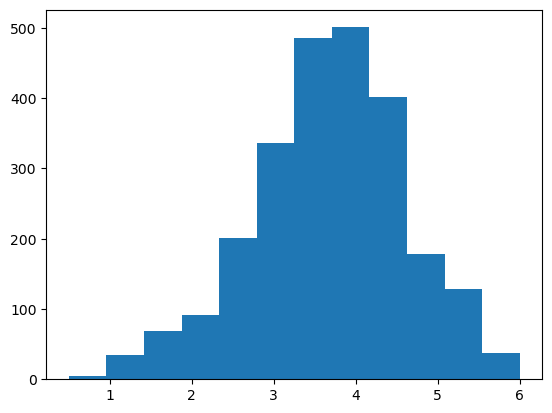

In [97]:
import matplotlib.pyplot as plt

plt.hist(df_labels['score'], bins = 12)
plt.show()

<Axes: xlabel='score'>

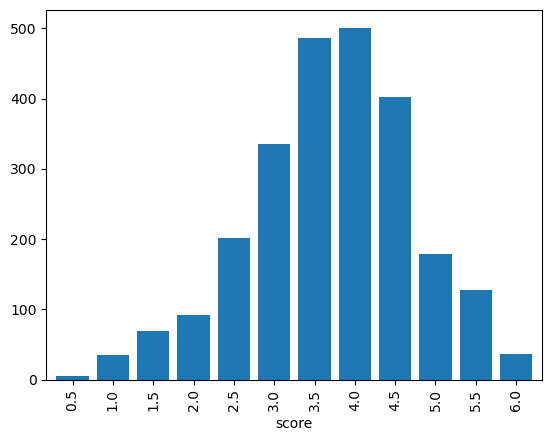

In [98]:
df_labels.groupby('score')['id'].count().plot.bar(width =0.8)